In [3]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import statsmodels.formula.api as sm

## Data

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe (1/0) a term deposit (variable y).

This dataset provides the customer information. It includes 41188 records and 21 fields.

In [4]:
data = pd.read_csv('bank2.csv', header=0)
data = data.dropna()
print(data.shape)
print(list(data.columns))

(41188, 21)
['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']


In [5]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no


#### Input variables

1 - age (numeric)

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')

8 - contact: contact communication type (categorical: 'cellular','telephone')

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

16 - emp.var.rate: employment variation rate - (numeric)

17 - cons.price.idx: consumer price index - (numeric)

18 - cons.conf.idx: consumer confidence index - (numeric) 

19 - euribor3m: euribor 3 month rate - (numeric)

20 - nr.employed: number of employees - (numeric)

#### Predict variable (desired target):

y - has the client subscribed a term deposit? (binary: '1','0')

The education column of the dataset has many categories and we need to reduce the categories for a better modelling. The education column has the following categories:

In [6]:
data['education'].unique()

array(['basic.4y', 'high.school', 'basic.6y', 'basic.9y',
       'professional.course', 'unknown', 'university.degree',
       'illiterate'], dtype=object)

Let us group "basic.4y", "basic.9y" and "basic.6y" together and call them "basic".

In [7]:
data['education']=np.where(data['education'] =='basic.9y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.6y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.4y', 'Basic', data['education'])

After grouping, this is the columns

In [8]:
data['education'].unique()

array(['Basic', 'high.school', 'professional.course', 'unknown',
       'university.degree', 'illiterate'], dtype=object)

### Data exploration

In [9]:
data['y'].value_counts()

no     36548
yes     4640
Name: y, dtype: int64

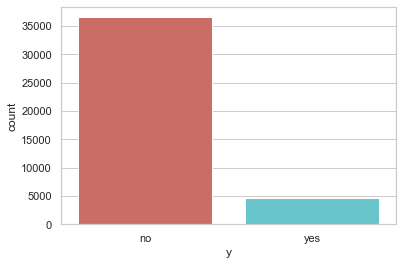

<Figure size 432x288 with 0 Axes>

In [10]:
sns.countplot(x='y',data=data, palette='hls')
plt.show()
plt.savefig('count_plot')

There are 36548 no's and 4640 yes's in the outcome variables.

Let's get a sense of the numbers across the two classes

In [11]:
data.groupby('y').mean()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
y,,,,,,,,,,
no,39.911185,220.844807,2.633085,984.113878,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.136752
yes,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.201078


Observations:

The average age of customers who bought the term deposit is higher than that of the customers who didn't.
The pdays (days since the customer was last contacted) is understandably lower for the customers who bought it. The lower the pdays, the better the memory of the last call and hence the better chances of a sale.
Surprisingly, campaigns (number of contacts or calls made during the current campaign) are lower for customers who bought the term deposit.

We can calculate categorical means for other categorical variables such as education and marital status to get a more detailed sense of our data.

In [12]:
data.groupby('job').mean()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
job,,,,,,,,,,
admin.,38.187296,254.312128,2.623489,954.319229,0.189023,0.015563,93.534054,-40.245433,3.550274,5164.112263
blue-collar,39.555760,264.542360,2.558461,985.160363,0.122542,0.248995,93.656656,-41.375816,3.771996,5175.569051
entrepreneur,41.723214,263.267857,2.535714,981.267170,0.138736,0.158723,93.605372,-41.283654,3.791120,5176.304258
housemaid,45.500000,250.454717,2.639623,960.579245,0.137736,0.433396,93.676576,-39.495283,4.009645,5179.514151
management,42.362859,257.058140,2.476060,962.647059,0.185021,-0.012688,93.522755,-40.489466,3.611316,5166.660739
retired,62.027326,273.712209,2.476744,897.936047,0.327326,-0.698314,93.430786,-38.573081,2.770066,5122.329651
self-employed,39.949331,264.142153,2.660802,976.621393,0.143561,0.094159,93.559982,-40.488107,3.689376,5170.664321
services,37.926430,258.398085,2.587805,979.974049,0.154951,0.175359,93.634659,-41.290048,3.699187,5171.564626
student,25.894857,283.683429,2.104000,840.217143,0.524571,-1.408000,93.331613,-40.187543,1.884224,5086.005714


In [13]:
data.groupby('marital').mean()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
marital,,,,,,,,,,
divorced,44.899393,253.790330,2.61340,968.639853,0.168690,0.163985,93.606563,-40.707069,3.715603,5170.865351
married,42.307165,257.438623,2.57281,967.247673,0.155608,0.183625,93.597367,-40.270659,3.745832,5171.830151
single,33.158714,261.524378,2.53380,949.909578,0.211359,-0.167989,93.517300,-40.918698,3.317447,5155.184734
unknown,40.275000,312.725000,3.18750,937.100000,0.275000,-0.221250,93.471250,-40.820000,3.313038,5157.362500


In [14]:
data.groupby('education').mean()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
education,,,,,,,,,,
Basic,42.163910,263.043874,2.559498,974.877967,0.141053,0.191329,93.639933,-40.927595,3.729654,5171.984336
high.school,37.998213,260.886810,2.568576,964.358382,0.185917,0.032937,93.584857,-40.940641,3.556157,5164.974356
illiterate,48.500000,276.777778,2.277778,943.833333,0.111111,-0.133333,93.317333,-39.950000,3.516556,5171.722222
professional.course,40.080107,252.533855,2.586115,960.765974,0.163075,0.173012,93.569864,-40.124108,3.710457,5170.139615
university.degree,38.879191,253.223373,2.563527,951.807692,0.192390,-0.028090,93.493466,-39.975805,3.529663,5163.222387
unknown,43.481225,262.390526,2.596187,942.830734,0.226459,0.059099,93.658615,-39.877816,3.571098,5159.552282


Visualizations

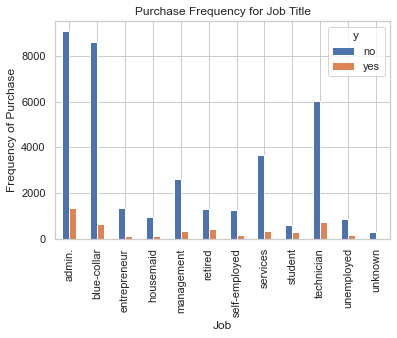

In [15]:
%matplotlib inline
pd.crosstab(data.job,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')
plt.savefig('purchase_fre_job')

The frequency of purchase of the deposit depends a great deal on the job title. Thus, the job title can be a good predictor of the outcome variable.

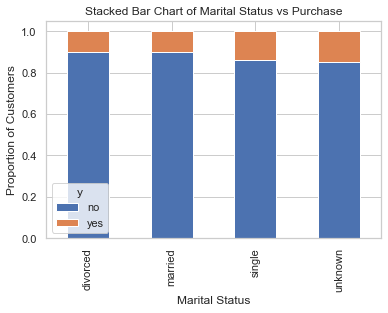

In [16]:
table=pd.crosstab(data.marital,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Marital Status vs Purchase')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')
plt.savefig('mariral_vs_pur_stack')

Hard to see, but the marital status does not seem a strong predictor for the outcome variable.

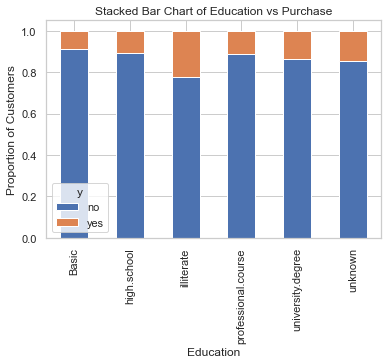

In [17]:
table=pd.crosstab(data.education,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Education vs Purchase')
plt.xlabel('Education')
plt.ylabel('Proportion of Customers')
plt.savefig('edu_vs_pur_stack')

Education seems a good predictor of the outcome variable.

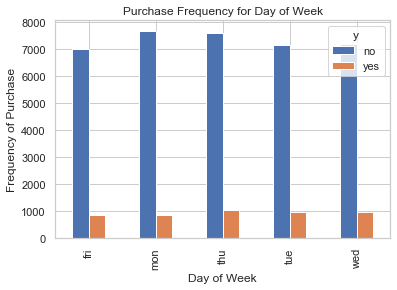

In [18]:
pd.crosstab(data.day_of_week,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_dayofweek_bar')

Day of week may not be a good predictor of the outcome

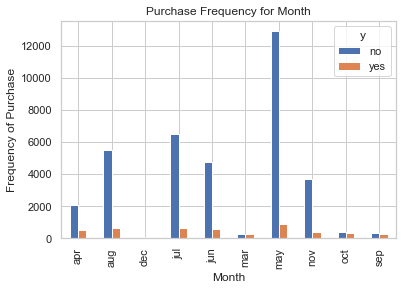

In [19]:
pd.crosstab(data.month,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Month')
plt.xlabel('Month')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_fre_month_bar')

Month might be a good predictor of the outcome variable

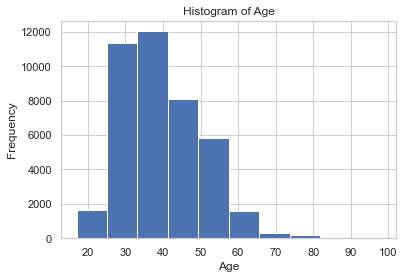

In [20]:
data.age.hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('hist_age')

The most of the customers of the bank in this dataset are in the age range of 30-40.

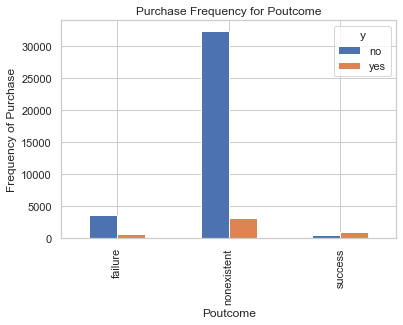

In [21]:
pd.crosstab(data.poutcome,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Poutcome')
plt.xlabel('Poutcome')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_fre_pout_bar')

Poutcome seems to be a good predictor of the outcome variable.

### Create dummy variables

In [22]:
cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(data[var], prefix=var)
    data1=data.join(cat_list)
    data=data1

In [23]:
cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

In [24]:
data_final=data[to_keep]
data_final.columns.values

array(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_Basic', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_no',
       'default_unknown', 'default_yes', 'housing_no', 'housing_unknown',
       'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
       'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri',

In [25]:
data_final_vars=data_final.columns.values.tolist()
y=['y']
X=[i for i in data_final_vars if i not in y]

### Feature Selection

In [26]:
data_final[X]

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191,...,0,0,0,1,0,0,0,0,1,0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191,...,0,0,0,1,0,0,0,0,1,0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191,...,0,0,0,1,0,0,0,0,1,0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191,...,0,0,0,1,0,0,0,0,1,0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,334,1,999,0,-1.1,94.767,-50.8,1.028,4964,...,0,0,1,0,0,0,0,0,1,0
41184,46,383,1,999,0,-1.1,94.767,-50.8,1.028,4964,...,0,0,1,0,0,0,0,0,1,0
41185,56,189,2,999,0,-1.1,94.767,-50.8,1.028,4964,...,0,0,1,0,0,0,0,0,1,0
41186,44,442,1,999,0,-1.1,94.767,-50.8,1.028,4964,...,0,0,1,0,0,0,0,0,1,0


In [27]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

rfe = RFE(logreg, n_features_to_select=20,step=2)
rfe = rfe.fit(data_final[X],data_final[y] )
print(rfe.support_)
print(rfe.ranking_)

C:\Users\rajat.k.srivastava\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\rajat.k.srivastava\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\rajat.k.srivastava\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape 

[False False False False  True False False False  True False False  True
 False False False  True False  True  True False False False False False
 False False False False False False False  True  True False False False
 False False False False False  True False  True  True  True False False
  True  True  True  True False False  True False False  True  True False
  True]
[18 17  4 19  1  5 11  7  1 13 12  1 14 19 20  1 20  1  1  9 14 21  7 12
  5 22 10  9 21 13  3  1  1  8 22 18 16 17  6 16 15  1  8  1  1  1  2  6
  1  1  1  1 15 11  1  4  3  1  1 10  1]


The Recursive Feature Elimination (RFE) has helped us select the following features: "previous", "euribor3m", "job_blue-collar", "job_retired", "job_services", "job_student", "default_no", "month_aug", "month_dec", "month_jul", "month_nov", "month_oct", "month_sep", "day_of_week_fri", "day_of_week_wed", "poutcome_failure", "poutcome_nonexistent", "poutcome_success".

In [28]:
cols=["previous", "euribor3m", "job_blue-collar", "job_retired", "job_services", "job_student", "default_no", 
      "month_aug", "month_dec", "month_jul", "month_nov", "month_oct", "month_sep", "day_of_week_fri", "day_of_week_wed", 
      "poutcome_failure", "poutcome_nonexistent", "poutcome_success"] 
X=data_final[cols]
y=data_final['y']

In [29]:
X

,previous,euribor3m,job_blue-collar,job_retired,job_services,job_student,default_no,month_aug,month_dec,month_jul,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0,4.857,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,0,4.857,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,4.857,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0
3,0,4.857,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,0,4.857,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,0,1.028,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0
41184,0,1.028,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0
41185,0,1.028,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0
41186,0,1.028,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0


In [30]:
y=pd.Series(np.where(y == 'yes', 1, 0),
          y.index)

In [31]:
X.to_numpy()

array([[0.   , 4.857, 0.   , ..., 0.   , 1.   , 0.   ],
       [0.   , 4.857, 0.   , ..., 0.   , 1.   , 0.   ],
       [0.   , 4.857, 0.   , ..., 0.   , 1.   , 0.   ],
       ...,
       [0.   , 1.028, 0.   , ..., 0.   , 1.   , 0.   ],
       [0.   , 1.028, 0.   , ..., 0.   , 1.   , 0.   ],
       [1.   , 1.028, 0.   , ..., 1.   , 0.   , 0.   ]])

In [32]:
from statsmodels.tools.tools import add_constant

In [33]:
X=add_constant(X)

### Implementing the model

In [34]:
y

0        0
1        0
2        0
3        0
4        0
        ..
41183    1
41184    0
41185    0
41186    1
41187    0
Length: 41188, dtype: int32

In [35]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.287116
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                41188
Model:                          Logit   Df Residuals:                    41170
Method:                           MLE   Df Model:                           17
Date:                Thu, 16 Feb 2023   Pseudo R-squ.:                  0.1844
Time:                        20:10:26   Log-Likelihood:                -11826.
converged:                       True   LL-Null:                       -14499.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.7218   1.58e+06  -4.56e-07      1.000    -3.1e+06     3.1e+06

The p-values for most of the variables are very small, therefore, most of them are significant to the model.

### Logistic Regression Model Fitting

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

#### Predicting the test set results and caculating the accuracy

In [37]:
y_pred = logreg.predict(X_test)

In [38]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.90


### Cross Validation

In [39]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=10)
modelCV = LogisticRegression()
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.898


### Confusion Matrix

In [40]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[10838   131]
 [ 1137   251]]


The result is telling us that we have 10872+254 correct predictions and 1122+109 incorrect predictions.

#### Accuracy

In [41]:
from sklearn.metrics import accuracy_score
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(accuracy_score(y_pred, y_test)))

Accuracy of logistic regression classifier on test set: 0.90


#### Compute precision, recall, F-measure and support

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

The F-beta score weights recall more than precision by a factor of beta. beta == 1.0 means recall and precision are equally important.

The support is the number of occurrences of each class in y_test.

In [42]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.94     10969
           1       0.66      0.18      0.28      1388

    accuracy                           0.90     12357
   macro avg       0.78      0.58      0.61     12357
weighted avg       0.88      0.90      0.87     12357



#### Interpretation: 

Of the entire test set, 88% of the promoted term deposit were the term deposit that the customers liked. Of the entire test set, 90% of the customer's preferred term deposit were promoted.

### ROC Curvefrom sklearn import metrics
from ggplot import *

prob = clf1.predict_proba(X_test)[:,1]
fpr, sensitivity, _ = metrics.roc_curve(Y_test, prob)

df = pd.DataFrame(dict(fpr=fpr, sensitivity=sensitivity))
ggplot(df, aes(x='fpr', y='sensitivity')) +\
    geom_line() +\
    geom_abline(linetype='dashed')

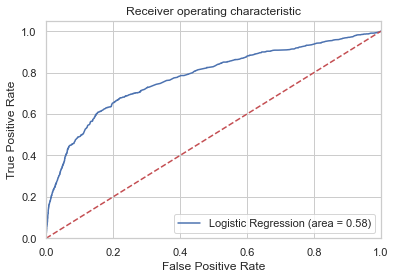

In [43]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()